# Redes neuronales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import f1_score
import math
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import L2
import seaborn as sns
import time

## Carga de datos

In [2]:
train = pd.read_csv('data/train.csv')
val = pd.read_csv('data/val.csv')
test = pd.read_csv('data/test.csv')

In [3]:
X_train = train.copy().drop(columns=['fetal_health'])
y_train = train['fetal_health']

X_val = val.copy().drop(columns=['fetal_health'])
y_val = val['fetal_health']

X_test = test.copy().drop(columns=['fetal_health'])
y_test = test['fetal_health']

# Reducir en 1 todas las y's
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

## Ajuste del modelo

### Exploración de hiperparámetros
Comenzamos haciendo una búsqueda exhaustiva de hiperparámetros para una red neuronal regularizada. Itera sobre diferentes combinaciones de hiperparámetros, probamos a usar tres o cuatro capas, distintos ratios de aprendizaje y distintas lambdas para la regularización. También se define y compila un modelo de red neuronal regularizado con la arquitectura correspondiente, entrena el modelo utilizando un conjunto de entrenamiento y evalúa su rendimiento en el set de validación. Luego, se actualiza el mejor modelo y se registra la F1 score obtenida junto con los hiperparámetros utilizados.

Para las capas internas vamos a usar relu como función de activación y para la salida una capa lineal, dado que para el error usaremos el Cross Entropy Loss partiendo de logits (mejor precisión que con una softmax antes). El optimizador será Adam, ya que da mejores resultados que SGD.

In [19]:
# Definir los hiperparámetros a probar
num_layers_list = [2, 3, 4]
layer_size_list = [128, 64, 32, 16]
learning_rate_list = [0.0001, 0.001, 0.01, 0.1]
lambda_list = [0.0001, 0.001, 0.01, 0.1]

best_f1 = 0
best_model = None
best_hyperparameters = {}
best_history = None
history_list = []

In [27]:
init_time = time.time()
# Iterar sobre los hiperparámetros
for num_layers in num_layers_list:
    for learning_rate in learning_rate_list:
        for lambda_value in lambda_list:
            print(f"Num Layers: {num_layers}, Learning Rate: {learning_rate}, Lambda: {lambda_value}")
            layer_size = []
            # Definir la arquitectura de la red neuronal
            model = tf.keras.Sequential()
            model.add(tf.keras.layers.Dense(layer_size_list[0], activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=L2(lambda_value)))
            layer_size.append(layer_size_list[0])
            for i in range(num_layers - 1):
                model.add(tf.keras.layers.Dense(layer_size_list[i+1], activation='relu', kernel_regularizer=L2(lambda_value)))
                layer_size.append(layer_size_list[i+1])
            model.add(tf.keras.layers.Dense(3, activation='linear', kernel_regularizer=L2(lambda_value)))

            # Compilar el modelo
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                            loss=SparseCategoricalCrossentropy(from_logits=True),
                            metrics=['accuracy'])
            
            # Entrenar el modelo
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=0)

            # calcular f1
            y_pred = model.predict(X_val)
            y_pred = np.argmax(y_pred, axis=1)
            f1 = f1_score(y_val, y_pred, average='weighted')

            history_list.append(history)
            # Actualizar el mejor modelo y su precisión en funcion de f1
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_history = history
                best_hyperparameters = {
                    'Num Layers': num_layers,
                    'Layer Size': layer_size,
                    'Learning Rate': learning_rate,
                    'Lambda': lambda_value
                }
                print(f"Num Layers: {num_layers}, Layer Size: {layer_size}, Learning Rate: {learning_rate}, Lambda: {lambda_value}")

print('Time: ', (time.time() - init_time)/60)

Num Layers: 2, Learning Rate: 0.0001, Lambda: 0.0001
14/14 [==============================] - 0s 619us/step
Num Layers: 2, Learning Rate: 0.0001, Lambda: 0.001
14/14 [==============================] - 0s 732us/step
Num Layers: 2, Learning Rate: 0.0001, Lambda: 0.01
14/14 [==============================] - 0s 638us/step
Num Layers: 2, Learning Rate: 0.0001, Lambda: 0.1
14/14 [==============================] - 0s 655us/step
Num Layers: 2, Learning Rate: 0.001, Lambda: 0.0001
14/14 [==============================] - 0s 655us/step
Num Layers: 2, Learning Rate: 0.001, Lambda: 0.001
14/14 [==============================] - 0s 654us/step
Num Layers: 2, Learning Rate: 0.001, Lambda: 0.01
14/14 [==============================] - 0s 655us/step
Num Layers: 2, Learning Rate: 0.001, Lambda: 0.1
14/14 [==============================] - 0s 616us/step
Num Layers: 2, Learning Rate: 0.01, Lambda: 0.0001
14/14 [==============================] - 0s 654us/step
Num Layers: 2, Learning Rate: 0.01, Lambda: 0.

### Selección de hiperparámetros

In [28]:
best_hyperparameters

{'Num Layers': 4,
 'Layer Size': [128, 64, 32, 16],
 'Learning Rate': 0.01,
 'Lambda': 0.001}

In [29]:
# Mostrar el mejor modelo encontrado
print("Best Model:")
print(best_model.summary())

# Evaluar el mejor modelo en el conjunto de prueba
print(f"Best Test F1: {best_f1}")

Best Model:
Model: "sequential_236"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_937 (Dense)           (None, 128)               3072      
                                                                 
 dense_938 (Dense)           (None, 64)                8256      
                                                                 
 dense_939 (Dense)           (None, 32)                2080      
                                                                 
 dense_940 (Dense)           (None, 16)                528       
                                                                 
 dense_941 (Dense)           (None, 3)                 51        
                                                                 
Total params: 13,987
Trainable params: 13,987
Non-trainable params: 0
_________________________________________________________________
None
Best Test F1: 0.945872757596038

### Efecto de la regularización

Para poder apreciar el efecto de la regularización, entrenamos un modelo sin regularizar con los mejores hiperparámetros obtenidos anteriormente.

In [30]:
# Modelo con mejores hiperparámetros sin regularización
best_learning_rate = best_hyperparameters['Learning Rate']
best_num_layers = best_hyperparameters['Num Layers']
model_sr = tf.keras.Sequential()
model_sr.add(tf.keras.layers.Dense(layer_size_list[0], activation='relu', input_shape=(X_train.shape[1],)))
for i in range(best_num_layers - 1):
    model_sr.add(tf.keras.layers.Dense(layer_size_list[i+1], activation='relu'))
model_sr.add(tf.keras.layers.Dense(3, activation='linear'))

# Compilar el modelo
model_sr.compile(optimizer=tf.keras.optimizers.Adam(best_learning_rate),
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

# Entrenar el modelo
history_sr = model_sr.fit(X_train, y_train, epochs=100, verbose=0)

# F1
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
f1_sr = f1_score(y_val, y_pred, average='weighted')
print("F1 eval: ", f1_sr)


14/14 [==============================] - 0s 615us/step
F1 eval:  0.6826960000990994


Como podemos observar, el modelo regularizado tiene un rendimiento muy superior al modelo sin regularizar. Esto se debe a que la regularización permite que el modelo generalice mejor, evitando el sobreajuste que se está produciendo en este caso. Veremos gráficas más adelante que lo confirman. 

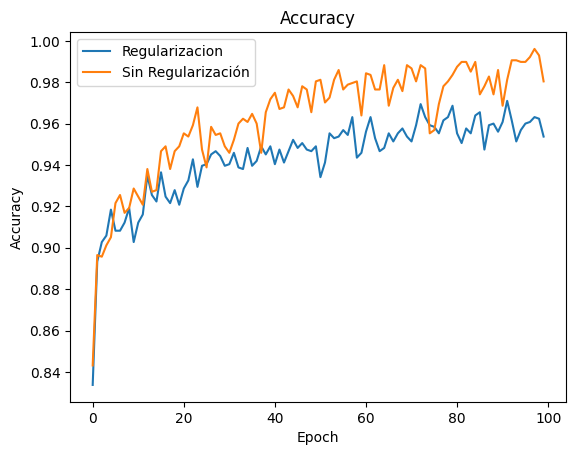

In [31]:
def plot_acc_curve(history, hist, title):
    plt.plot(history.history['accuracy'], label='Regularizacion')
    plt.plot(hist.history['accuracy'], label='Sin Regularización')
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_acc_curve(best_history, history_sr, "Accuracy")

Efectivamente, el modelo sin reguilarizar memoriza los datos de entrada (hace overfitting) ligeramente más que el modelo con regularización, llegando a una accuracy de casi el 100%

### Curvas de aprendizaje

Se evalúa el rendimiento del mejor modelo obtenido a medida que aumenta la cantidad de datos de entrenamiento, aumentamos la cantidad en un 15% cada iteración. Se muestra cómo evoluciona tanto el rendimiento en el conjunto de entrenamiento como en el conjunto de validación a medida que se incrementa el tamaño del conjunto de entrenamiento.

Cuando las curvas de entrenamiento y validación convergen a un rendimiento similar a medida que se aumenta el tamaño del conjunto de entrenamiento, se considera que el modelo está generalizando bien y no sufre de sobreajuste (overfitting) ni subajuste (underfitting). En este caso, el modelo ha encontrado un equilibrio entre la capacidad de aprendizaje y la capacidad de generalización.

La segunda gráfica muestra un entrenamiento con los mismos parámetros pero sin regularización, se aprecia una clara tendencia a separarse las curvas de validación y de entrenamiento, es decir, overfitting.

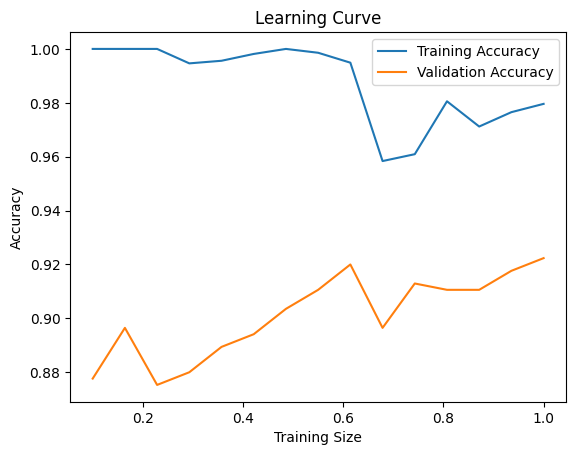

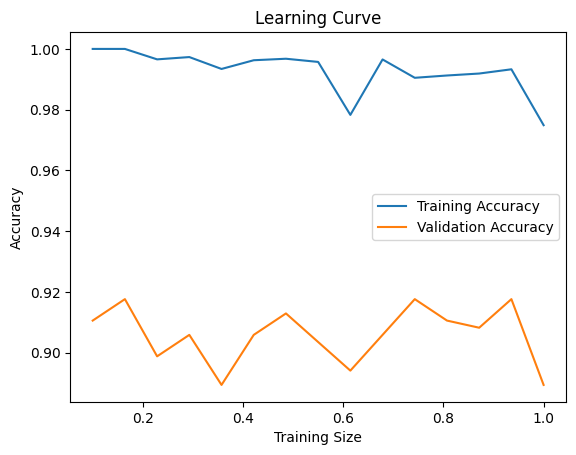

In [32]:
def learning_curve_data(model, X_train, y_train, X_val, y_val):
    train_sizes = np.linspace(0.1, 1, 15) # 15% de los datos
    train_sizes_abs = np.multiply(train_sizes, X_train.shape[0]).astype(int)
    train_scores = []
    val_scores = []
    for train_size in train_sizes_abs:
        model.fit(X_train[:train_size], y_train[:train_size], epochs=100, verbose=0)
        _, train_accuracy = model.evaluate(X_train[:train_size], y_train[:train_size], verbose=0)
        _, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
        train_scores.append(train_accuracy)
        val_scores.append(val_accuracy)
    return train_sizes, train_scores, val_scores

def plot_learning_curve(train_sizes, train_scores, val_scores):
    plt.plot(train_sizes, train_scores, label='Training Accuracy')
    plt.plot(train_sizes, val_scores, label='Validation Accuracy')
    plt.title('Learning Curve')
    plt.ylabel('Accuracy')
    plt.xlabel('Training Size')
    plt.legend()
    plt.show()

train_sizes, train_scores, val_scores = learning_curve_data(best_model, X_train, y_train, X_test, y_test)
plot_learning_curve(train_sizes, train_scores, val_scores)

train_sizes, train_scores, val_scores = learning_curve_data(model_sr, X_train, y_train, X_test, y_test)
plot_learning_curve(train_sizes, train_scores, val_scores)

### Entrenamiento Final

Para entrenar el modelo final, juntamos los datasets de entrenamiento y validación. También medimos el tiempo de entrenamiento.

In [33]:
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

In [34]:
init_time = time.time()
# Modelo con mejores hiperparámetros con regularización
best_learning_rate = best_hyperparameters['Learning Rate']
best_num_layers = best_hyperparameters['Num Layers']
best_lambda = best_hyperparameters['Lambda']
best_model = tf.keras.Sequential()
best_model.add(tf.keras.layers.Dense(layer_size_list[0], activation='relu', input_shape=(X_train_val.shape[1],), kernel_regularizer=L2(best_lambda)))
for i in range(best_num_layers - 1):
    best_model.add(tf.keras.layers.Dense(layer_size_list[i+1], activation='relu', kernel_regularizer=L2(best_lambda)))
best_model.add(tf.keras.layers.Dense(3, activation='linear', kernel_regularizer=L2(best_lambda)))

# Compilar el modelo
best_model.compile(optimizer=tf.keras.optimizers.Adam(best_learning_rate),
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

# Entrenar el modelo
best_history = best_model.fit(X_train_val, y_train_val, epochs=100, verbose=0)

total_time = time.time() - init_time
print('Time: ', total_time)

# F1
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1: ", f1)


Time:  4.8932225704193115
14/14 [==============================] - 0s 628us/step
F1:  0.9065509363940419


## Análisis de resultados

Visualizamos la matriz de confusión. Se muestra el rendimiento del modelo al predecir las etiquetas de clase en comparación con las etiquetas verdaderas. 

14/14 [==============================] - 0s 616us/step


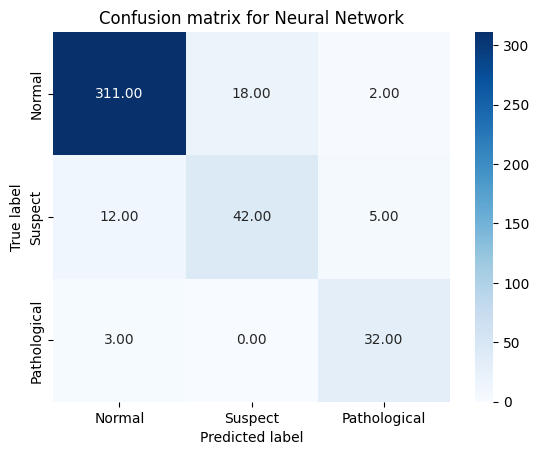

In [35]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = tf.math.confusion_matrix(y_true, y_pred)
    # sns settings
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=['Normal', 'Suspect', 'Pathological'], 
                yticklabels=['Normal', 'Suspect', 'Pathological'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for Neural Network')
    plt.show()
    
predictions = np.argmax(best_model.predict(X_test), axis=-1)
class_labels = ['Normal', 'Suspect', 'Pathological']
plot_confusion_matrix(y_test, predictions, class_labels)

El "recall" es una métrica utilizada en problemas de clasificación que evalúa la capacidad de un modelo para identificar correctamente los casos positivos. En nuestro caso, nos sirve para evaluar la última clase (patológico) que es la que más interesa detectar. Nuestro modelo cuenta con un recall del 91.42% que aunque no llega al nivel de la clase 'normal' es muy bueno para el modelo creado.

In [36]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, predictions, average=None)
recall

array([0.93957704, 0.71186441, 0.91428571])